In [1]:
import os, sys
import django
PROJECTPATH = '/opt/compute_node/'
sys.path.insert(0, PROJECTPATH)
os.environ.setdefault("REDIS_HOST", "redis_int")
os.environ.setdefault("REDIS_PORT", "6379")
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "compute_node.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"  # https://docs.djangoproject.com/en/4.1/topics/async/#async-safety
os.chdir(PROJECTPATH)
django.setup()

2024-04-01 18:08:02,343 ERROR[compute_node.compute_node.tasks.<module>:17]Failed to set GPIO mode - ignore if no GPIO
Traceback (most recent call last):
  File "/opt/compute_node/compute_node/tasks.py", line 15, in <module>
    import Jetson.GPIO as GPIO
ModuleNotFoundError: No module named 'Jetson'


In [2]:
from analysis.models import Material
from analysis.models import Classifier
import numpy as np
import pandas as pd

In [3]:
clf = Classifier.objects.get(pk=2)

In [5]:
for sdf in clf.yield_scan_dataframe(35):
    scan_df = sdf
    break

2024-04-01 18:08:35,207 INFO[compute_node.analysis.models.yield_scan_dataframe:81]Retrieving Scans from Disk
2024-04-01 18:09:24,964 INFO[compute_node.analysis.models.build_df:100]Built ScanDF:
      scanNum  galvoPos  timeStamp   
0  3856091400     18951        199  \
1  3856091401     19007        200   
2  3856091402     19036        200   
3  3856091403     19100        200   
4  3856091404     19136        201   

                                            vis_data   
0  (5089, 5084, 5075, 5116, 5122, 5112, 5112, 510...  \
1  (5076, 5083, 5084, 5090, 5113, 5104, 5106, 510...   
2  (5078, 5091, 5095, 5085, 5114, 5095, 5085, 510...   
3  (5058, 5082, 5081, 5081, 5103, 5107, 5097, 509...   
4  (5078, 5108, 5093, 5120, 5134, 5129, 5126, 511...   

                                             ir_data  
0  (64980, 65134, 65148, 64715, 65278, 65198, 652...  
1  (64975, 65134, 65151, 64728, 65283, 65199, 652...  
2  (64966, 65134, 65151, 64697, 65285, 65204, 652...  
3  (64968, 65138, 65

In [6]:
scan_df

scanNum  galvoPos  timeStamp   
0       3856091400     18951        199  \
1       3856091401     19007        200   
2       3856091402     19036        200   
3       3856091403     19100        200   
4       3856091404     19136        201   
...            ...       ...        ...   
608095  3856786859     34511     299791   
608096  3856786860     34647     299792   
608097  3856786861     34790     299792   
608098  3856786862     34922     299793   
608099  3856786863     35057     299793   

                                                 vis_data   
0       (5089, 5084, 5075, 5116, 5122, 5112, 5112, 510...  \
1       (5076, 5083, 5084, 5090, 5113, 5104, 5106, 510...   
2       (5078, 5091, 5095, 5085, 5114, 5095, 5085, 510...   
3       (5058, 5082, 5081, 5081, 5103, 5107, 5097, 509...   
4       (5078, 5108, 5093, 5120, 5134, 5129, 5126, 511...   
...                                                   ...   
608095  (5029, 5067, 5043, 5039, 5062, 5054, 5036, 504...   
608096  (5023, 5022, 5026, 5048, 5029, 5047, 5028, 501...   
608097  (5046, 5036, 5057, 5055, 5077, 5059, 5055, 505...   
608098  (5029, 5044, 5032, 5045, 5073, 5056, 5046, 503...   
608099  (5046, 5042, 5049, 5050, 5074, 5052, 5046, 505...   

                                                  ir_data  
0       (64980, 65134, 65148, 64715, 65278, 65198, 652...  
1       (64975, 65134, 65151, 64728, 65283, 65199, 652...  
2       (64966, 65134, 65151, 64697, 65285, 65204, 652...  
3       (64968, 65138, 65150, 64702, 65280, 65200, 652...  
4       (64969, 65132, 65149, 64712, 65284, 65200, 652...  
...                                                   ...  
608095  (64967, 65140, 65148, 64701, 65262, 65203, 651...  
608096  (64968, 65143, 65146, 64701, 65259, 65204, 651...  
608097  (64953, 65137, 65145, 64701, 65262, 65196, 651...  
608098  (64961, 65138, 65148, 64707, 65257, 65202, 651...  
608099  (64960, 65139, 65149, 64713, 65258, 65202, 651...  

[608100 rows x 5 columns]

In [9]:
scanNum_range = [3813727981, 3813795019]
galvo_range = [53391, 61529]

filtered_df = scan_df[
    (scan_df['scanNum'].between(*scanNum_range))
#     & (scan_df['galvoPos'].between(*galvo_range))
]
filtered_df

Empty DataFrame
Columns: [scanNum, galvoPos, timeStamp, vis_data, ir_data]
Index: []

In [7]:
from analysis.util import normalize

def yield_batch(queryset, batch_size=100):
    total_samples = queryset.count()
    start_index = 0
    while start_index < total_samples:
        batch_samples = queryset[start_index:start_index+batch_size]
        yield batch_samples
        start_index += batch_size

df = []
for idx, material in enumerate(clf.materials.all()):
    scan_samples = material.scans.order_by("scanNum")
    for idx2, batch in enumerate(yield_batch(scan_samples)):
        vis_data = normalize([
            scan.vis_data
            for scan in batch
        ])
        vis_data = np.median(vis_data, axis=0)
        df.append({"label":material.material_id, "signal": vis_data})
df = pd.DataFrame(df)
df

label                                             signal
0         fence  [-1.5836239553704354, -1.6252070111822254, -1....
1         fence  [-1.5847626151092533, -1.6114813176344849, -1....
2        piglet  [-2.030621445273839, -2.141395502906428, -1.99...
3        piglet  [-2.0663189410066383, -2.248850373993127, -2.0...
4        piglet  [-2.0041521675775176, -2.127128630568337, -1.9...
..          ...                                                ...
286  panel_blue  [-2.086397190727856, -2.1048305379124175, -2.0...
287  panel_blue  [-2.084630980725196, -2.0983973172926733, -2.0...
288  panel_blue  [-2.089044986844428, -2.1001901796191085, -2.0...
289  panel_blue  [-2.073942854820598, -2.0919494191914985, -2.0...
290  panel_blue  [-2.0717138873497545, -2.1049716419941094, -2....

[291 rows x 2 columns]

In [10]:
signatures = {
    f"{i}.{r.label}": r.signal
    for i, r in df.iterrows()
}
signatures

{'0.fence': array([-1.58362396, -1.62520701, -1.55444107, -1.56966616, -1.47982247,
        -1.51919092, -1.59279958, -1.54984709, -1.55544769, -1.53335828,
        -1.53555188, -1.57718488, -1.39790686, -1.38954914, -1.39442141,
        -1.37194536, -1.35365864, -1.35920556, -1.37823182, -1.48723085,
        -1.37572846, -1.36731659, -1.41542162, -1.36254815, -1.34078808,
        -1.2865062 , -1.14342221, -1.18886214, -1.06897739, -1.0071343 ,
        -0.98768471, -0.94541567, -0.96305117, -0.96554926, -0.99199154,
        -1.03834977, -0.99794227, -0.8818836 , -0.85717894, -0.79034301,
        -0.78210206, -0.71715597, -0.72648392, -0.70677815, -0.60876634,
        -0.5107278 , -0.4561521 , -0.40166379, -0.305121  , -0.30048879,
        -0.33651958, -0.37631119, -0.31097232, -0.27853556, -0.32473535,
        -0.34247531, -0.30217715, -0.33576249, -0.36649946, -0.33656914,
        -0.35664245, -0.35927716, -0.38034573, -0.31473542, -0.27872738,
        -0.28992677, -0.3634891 , -0.297

In [12]:
X_normalized = np.vstack(signatures.values())
X_normalized.shape

/tmp/ipykernel_33/2258372112.py:1: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



(291, 204)

In [25]:
from sklearn.decomposition import PCA
# Perform PCA on the normalized data
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_normalized)

In [85]:
df

label    signal
0     fence -1.362548
1     fence -1.357210
2    piglet -1.896352
3    piglet -1.937961
4    piglet -1.889280
..      ...       ...
276    goat -1.457233
277    goat -1.458653
278    goat -1.456650
279    goat -1.458752
280    goat -1.450101

[281 rows x 2 columns]

In [79]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# Fit and transform the categorical column
y = label_encoder.fit_transform(df['label'])
X = np.array(df.signal.to_list())

k = 20  # Number of top features to select
selector = SelectKBest(score_func=mutual_info_regression, k=k)
selected_indices = selector.fit(X, y).get_support(indices=True)

In [84]:
X[:, selected_indices].shape

(281, 20)

In [94]:
labels = df['label'].to_list()

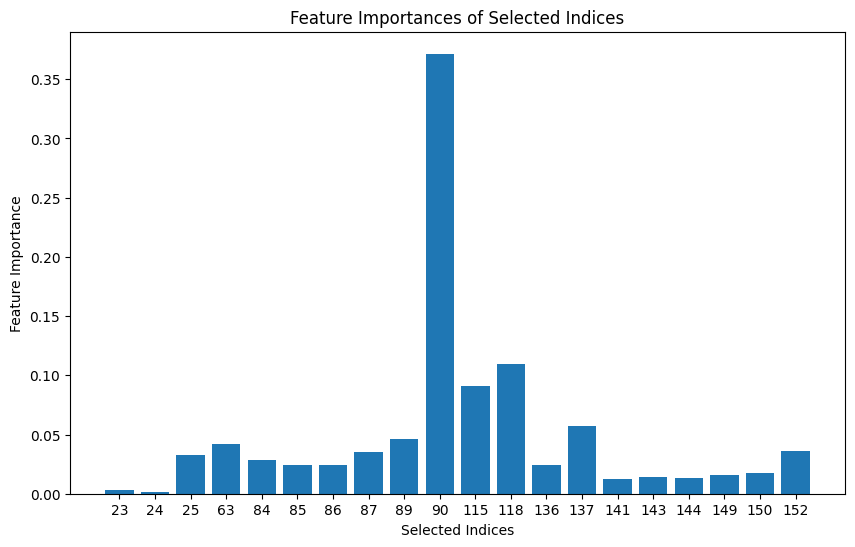

In [82]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Assuming 'X' is your original data array
# 'y' is the target variable
# 'selected_indices' contains the indices of selected features

# Train a Random Forest model
model = RandomForestRegressor()
model.fit(X[:, selected_indices], y)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_indices)), model.feature_importances_)
plt.xlabel('Selected Indices')
plt.ylabel('Feature Importance')
plt.title('Feature Importances of Selected Indices')
plt.xticks(range(len(selected_indices)), selected_indices)
plt.show()

In [96]:

signatures = {}
selected_X = X[:, selected_indices]
for i in range(len(y)):
    signatures[f"{i}.{labels[i]}"] = selected_X[i, :]
signatures

{'0.fence': array([-1.36254815, -1.34078808, -1.2865062 , -0.31473542,  1.31412871,
         1.42816996,  1.51859674,  1.5955362 ,  1.6527778 ,  1.64059669,
         1.289636  ,  1.61089643,  1.0070894 ,  0.9629428 ,  0.61983739,
         0.39919484,  0.30325782, -0.19520106, -0.28058077, -0.31725605]),
 '1.fence': array([-1.35720989, -1.32409541, -1.27660115, -0.32093768,  1.32464506,
         1.41651488,  1.52912356,  1.58134204,  1.64249359,  1.64976403,
         1.29450439,  1.61098325,  0.98045913,  0.95896823,  0.62314915,
         0.38474502,  0.29418407, -0.19623324, -0.28473287, -0.31098801]),
 '2.piglet': array([-1.89635199, -1.93028275, -1.88851303, -0.051582  ,  0.85480709,
         0.84321072,  0.89606282,  0.86582814,  0.87936756,  0.88659022,
         0.6579514 ,  1.1486023 ,  0.93104234,  0.90708886,  0.8663104 ,
         0.68897368,  0.59739023,  0.21731512,  0.16637163,  0.17328978]),
 '3.piglet': array([-1.93796134, -1.91968132, -1.87867165,  0.01683144,  0.77575755,

In [3]:
from sporian.models import Scan

In [5]:
s = Scan.objects.last()

In [8]:
!ls /data/scan_archives/

mission.1    mission.133  mission.138  mission.167  mission.175  mission.36
mission.105  mission.134  mission.139  mission.174  mission.34


In [10]:
s.scanNum

3856090938

In [22]:
scan_archives = {}
for root, dirs, files in os.walk("/data/scan_archives/"):
    for f in files:
        if not f.endswith(".pkl"):
            continue
        scannum = f.split(".")[1]
        scan_archives[scannum] = os.path.join(root, f)
keys = sorted(scan_archives.keys())

In [23]:
import bisect

def find_next_key(keys, given_number):
    index = bisect.bisect_right(keys, str(given_number))
    if index < len(keys):
        return keys[index]
    else:
        return None

In [32]:
given_number = s.scanNum
next_key = find_next_key(keys, given_number)
next_key

'3860228009'

In [33]:
scan_archives[next_key]

'/data/scan_archives/mission.36/scans.3860228009.pkl'

In [34]:
import pickle

In [35]:
with open(scan_archives[next_key], "rb") as f:
    dd = pickle.load(f)

In [36]:
dd

[b'\x02\x80\x00\x01\x04\xe9\xe5\x12H\x96\x00\x00\x00\x00\x00\x9b\xe6\x16g\xaehsi--teensy41--0.0.5+6ff2b92de0.11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00C\x99\x99\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00<\x1cF\x00\x00\x00\x00p\x12\x00\x02\x00\x06\xd7\xd5\x00D\x04\xe4vj\r\x8c\x13\xc8\x13\xd3\x13\xcb\x13\xcc\x13\xc2\x13\xb1\x13\xd0\x13\xca\x13\xc6\x13\xb3\x13\xb1\x13\xb4\x13\xc7\x13\xc2\x13\xd1\x13\xd7\x13\xc7\x13\xd7\x13\xcb\x13\xa9\x13\xba\x13\xb5\x13\xc2\x13\xcd\x13\xcd\x13\xc9\x13\xef\x13\xb7\x13\xbf\x13\xc9\x13\xd9\x13\xce\x13\xd7\x13\xe1\x13\xee\x13\xc7\x13\xcc\x13\xd6\x13\xed\x13\xe9\x13\xe3\x13\xd6\x13\xe8\x13\xd3\x13\xd7\x13\xd7\x13\xe3\x13\xee\x13\xec\x14\x03\x13\xf5\x13\xd0\x13\xd4\x13\xd6\x13\xe2\x13\xde\x13\xf4\x13\xe3\x13\xf0\x13\xee\x13\xde\x13\xf2\x13\xf3\x13\xfb\x13\xef\x14\x06\x13\xd7\x13\xed\x13\xd0\x13\xfb\x14\x03\x13\xf9\x13\xfe\x

In [45]:
import pandas as pd
scans = []
for l in dd:
    s = Scan.from_binary(l, s.mission, 0)
    scans.append({
        "scanNum": s.scanNum,
        "galvo_pos": s.galvoPos,
        "vis_data": s.vis_data,
        "ir_data": s.ir_data,
    })
scan_df = pd.DataFrame(scans)

In [10]:
print(scan_df.head())

      scanNum  galvoPos  timeStamp   
0  3856091400     18951        199  \
1  3856091401     19007        200   
2  3856091402     19036        200   
3  3856091403     19100        200   
4  3856091404     19136        201   

                                            vis_data   
0  (5089, 5084, 5075, 5116, 5122, 5112, 5112, 510...  \
1  (5076, 5083, 5084, 5090, 5113, 5104, 5106, 510...   
2  (5078, 5091, 5095, 5085, 5114, 5095, 5085, 510...   
3  (5058, 5082, 5081, 5081, 5103, 5107, 5097, 509...   
4  (5078, 5108, 5093, 5120, 5134, 5129, 5126, 511...   

                                             ir_data  
0  (64980, 65134, 65148, 64715, 65278, 65198, 652...  
1  (64975, 65134, 65151, 64728, 65283, 65199, 652...  
2  (64966, 65134, 65151, 64697, 65285, 65204, 652...  
3  (64968, 65138, 65150, 64702, 65280, 65200, 652...  
4  (64969, 65132, 65149, 64712, 65284, 65200, 652...  


In [13]:
for i, r in scan_df.iterrows():
    print(np.array(r.vis_data))
    break

[ 5089  5084  5075  5116  5122  5112  5112  5105  5107  5107  5112  5132
  5177  5166  5187  5177  5215  5217  5249  5235  5305  5347  5392  5530
  5735  5967  6292  6569  6837  7033  7207  7308  7264  7253  7247  7275
  7379  7583  7678  7893  8064  8275  8482  8686  8893  9152  9355  9678
  9859 10059 10195 10227 10187 10275 10315 10285 10187 10056 10027  9985
  9799  9731  9699  9811  9845  9947  9991 10016 10115 10235 10381 10499
 10595 10738 10885 10964 11002 11159 11290 11312 11403 11357 11291 11325
 11394 11390 11399 11376 11276 11156 11097 10934 10854 10684 10575 10559
 10450 10381 10217 10068  9900  9796  9719  9787  9852  9786  9739  9721
  9662  9527  9363  9094  9047  9135  9157  9182  9273  9311  9292  9069
  8672  8494  8559  8588  8751  9035  9161  9258  9291  9228  9148  8903
  8247  7312  7343  8059  8391  8417  8320  8148  7999  7817  7675  7520
  7423  7323  7199  7098  6925  6670  6521  6473  6476  6472  6557  7467
  8575  8124  7199  6463  6410  6341  6333  6343  6